In [36]:
import os
import pickle
import jieba
import operator
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jieba.analyse
import matplotlib.font_manager as font_manager
from datetime import datetime
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from modules import *


In [40]:
with open('liberty_times.pkl', 'rb') as f:
    data = pickle.load(f)
data = data[::-1]
#把data裡面每個dictionary其key=content的value裝入一個名為contents的list裡
contents = [news['content'] for news in data]

In [55]:
#把一個字串內的標點符號和單詞轉換成空格
def remove_punctuation(content_string, user_pc=False):
    if(user_pc):
        punctuation = user_pc
    else:
        punctuation=list("!@#$%^&*()_+=-[]`~'\"|/\\abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ,.;{}\r\xa0\u3000、，。「」！？；：<>")
        
    for p in punctuation:
        content_string = content_string.replace(p, " ")
    return(content_string)
#排序
def sort_dict_by_values(d):
    return(sorted(d.items(), key=lambda x: x[1], reverse=True))

def get_coshow(contents):
    coshow_dict = {}
    #Python:join()的方法用於將序列中的元素以指定的字符連接生成一個新的字符串。
    cat_content = ' '.join(contents) #string
    clean_content = remove_punctuation(cat_content)
    #.cut返回的是iterator,.1cut返回的是list
    cut_content = jieba.lcut(clean_content)
    #filter:過濾不符合條件的元素，lamba語法:參數為x(字元) 如果cut_content內的字元x不為空格，則返回之
    cut_content = list(filter(lambda x: x!=' ', cut_content))  
    #計算每個字彙的次數
    for i in range(len(cut_content)-1):
        wcw = cut_content[i] + cut_content[i+1]
        #try-except處理例外
        try:  
            coshow_dict[wcw] = coshow_dict[wcw] + 1
        except:
            coshow_dict[wcw] = 1

    sdbv = sort_dict_by_values(coshow_dict)
    return sdbv

In [56]:
get_coshow(contents[:1000])[:10]

[('報導〕', 245),
 ('二○', 238),
 ('〔記者', 236),
 ('／台北', 149),
 ('台北報導', 149),
 ('（）', 93),
 ('○一', 87),
 ('○二', 70),
 ('／綜合', 60),
 ('綜合報導', 60)]

In [57]:
#設定繁體中文辭典
jieba.set_dictionary('dict.txt.big.txt')
#載入辭典
jieba.load_userdict('userdict.txt')
stopwords = []
with open('stopwords.txt', 'r', encoding='UTF-8') as file:
    for each in file.readlines():
        stopwords.append(each.strip()) #strip() : 移除首尾空格
    stopwords.append(' ')

Building prefix dict from C:\Users\msi\Desktop\資料科學分析\dict.txt.big.txt ...
Loading model from cache C:\Users\msi\AppData\Local\Temp\jieba.u04747de80de5fa162843332f1d257bf3.cache
Loading model cost 1.404 seconds.
Prefix dict has been built succesfully.


In [58]:
def lcut_to_dict(lcut):
    word_dict = dict(Counter(lcut))
    return(remove_stopwords_from_dict(word_dict, stopwords))

def remove_stopwords_from_dict(word_dict, stopwords):
    for w in stopwords:
        word_dict.pop(w, word_dict)
    return word_dict


for i in range(len(data)):
    current_content = data[i]['content']
    current_cutted = jieba.lcut(remove_punctuation(current_content)) #把一個字串內的標點符號和單詞轉換成空格
    data[i]['cutted_dict'] = lcut_to_dict(current_cutted)

In [48]:
def get_cutted_dict(list_of_news):
    cat = ' '.join(list_of_news)
    cat = remove_punctuation(cat)
    cutted = jieba.lcut(cat)
    return lcut_to_dict(cutted)

def first_n_words(cutted_dict, n, word_len=2, to=1000):
    sdbv = sort_dict_by_values(cutted_dict)
    return list(filter(lambda x: len(x[0])>=word_len and len(x[0])<=to, sdbv))[:n]


cutted_dict = get_cutted_dict(contents[:1000])
high_freq_pair = first_n_words(cutted_dict, 20)
high_freq_pair

[('台灣', 513),
 ('中國', 427),
 ('報導', 267),
 ('記者', 263),
 ('國民黨', 233),
 ('美國', 231),
 ('韓國瑜', 186),
 ('台北', 184),
 ('指出', 169),
 ('朱立倫', 147),
 ('民進黨', 130),
 ('政府', 125),
 ('兩岸', 121),
 ('希望', 119),
 ('立委', 118),
 ('去年', 113),
 ('王金平', 111),
 ('總統', 109),
 ('國家', 105),
 ('未來', 102)]

In [49]:
cutted_dict = get_cutted_dict(contents)

In [50]:
# 可能人名
possible_name = first_n_words(cutted_dict, 1000, 3, 3)
possible_name[:10]

[('國民黨', 233),
 ('韓國瑜', 186),
 ('朱立倫', 147),
 ('民進黨', 130),
 ('王金平', 111),
 ('立法院', 76),
 ('行政院', 71),
 ('陸委會', 64),
 ('吳敦義', 62),
 ('二二八', 52)]

In [51]:
# 可能事件
possible_events = first_n_words(cutted_dict, 200, 4)
possible_events[:10]

[('行政院長蘇貞昌', 49),
 ('高雄市長韓國瑜', 49),
 ('一國兩制', 48),
 ('國民黨立委', 47),
 ('參選總統', 43),
 ('民進黨立委', 41),
 ('九二共識', 39),
 ('蔡英文總統', 36),
 ('總統大選', 33),
 ('新北市長朱立倫', 31)]

3687


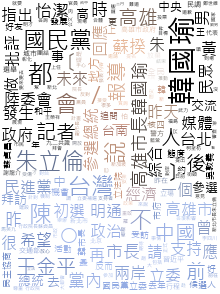

In [52]:
def news_containing_keyword(keyword, news_list):
    return list(filter(lambda news: keyword in news, news_list))

def get_wordcloud_of_keywords(keywords, list_of_news, image_path=False):
    if type(keywords) == str:
        keywords = [keywords]
    
    if image_path:
        coloring = np.array(Image.open(os.path.join(image_path)))
        color_func = ImageColorGenerator(coloring)
        wc = WordCloud(max_font_size=30,
                       background_color="white",
                       mask=coloring,
                       color_func=color_func,
                       font_path=font_path,
                       width=1000, height=1000,
                      max_words=10000)
    else:
        wc = WordCloud(max_font_size=30,
                       background_color="white",
                       colormap='Set2',
                       font_path=font_path,
                       width=1000, height=300,
                      max_words=1000)
    
    keyword_news = news_containing_keywords(keywords, list_of_news)
    keyword_dict = get_cutted_dict(keyword_news)
    print(len(keyword_dict))
    im = wc.generate_from_frequencies(keyword_dict)
    return im

# 韓國瑜
ten_wc = get_wordcloud_of_keywords('韓國瑜', contents, '66.png')
ten_wc.to_image()